Starting SSH model simulation...
Parameters: t1=2, t2=1, A=0.5, Nc=10
Time range: 0 to 400.00, 400001 time steps
k-points: 251
Processing k-point 1/251
Processing k-point 2/251
Processing k-point 3/251
Processing k-point 4/251
Processing k-point 5/251
Processing k-point 6/251
Processing k-point 7/251
Processing k-point 8/251
Processing k-point 9/251
Processing k-point 10/251
Processing k-point 11/251
Processing k-point 12/251
Processing k-point 13/251
Processing k-point 14/251
Processing k-point 15/251
Processing k-point 16/251
Processing k-point 17/251
Processing k-point 18/251
Processing k-point 19/251
Processing k-point 20/251
Processing k-point 21/251
Processing k-point 22/251
Processing k-point 23/251
Processing k-point 24/251
Processing k-point 25/251
Processing k-point 26/251
Processing k-point 27/251
Processing k-point 28/251
Processing k-point 29/251
Processing k-point 30/251
Processing k-point 31/251
Processing k-point 32/251
Processing k-point 33/251
Processing k-point 34/25

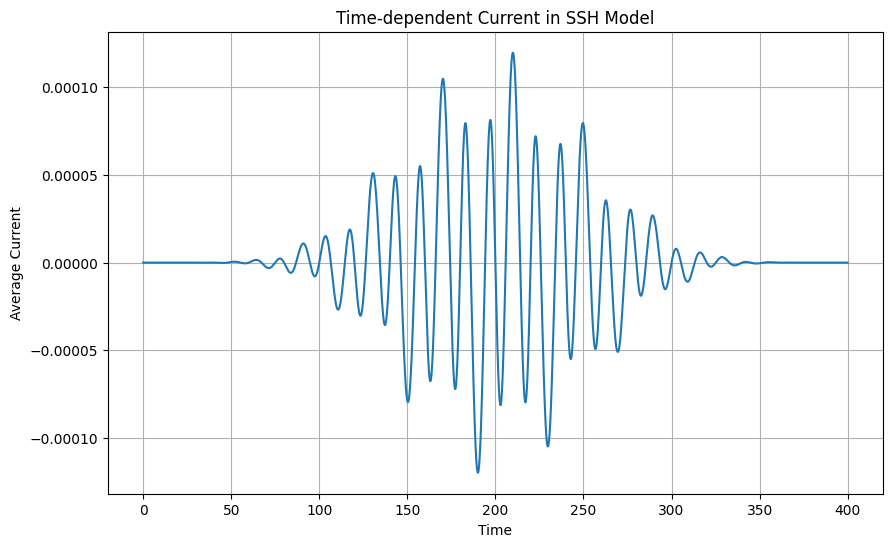

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import trapezoid

class SSHModel:
    def __init__(self, t1=2, t2=1, A=0.5, Nc=10, omega0=None):
        self.t1 = t1
        self.t2 = t2
        self.A = A
        self.Nc = Nc
        self.omega0 = omega0 if omega0 is not None else np.pi/(2*Nc)
        self.T = 2 * np.pi * Nc / self.omega0
        
        # k-space discretization
        self.nk = 251
        self.k_values = np.linspace(-np.pi, np.pi, self.nk, endpoint=False)
        self.dk = 2 * np.pi / self.nk
        
        # Time discretization
        self.dt = 0.001
        self.t_values = np.arange(0, self.T + self.dt, self.dt)
        self.nt = len(self.t_values)
        
    def A_t(self, t):
        """Time-dependent vector potential"""
        return self.A * np.sin(self.omega0 * t) * np.sin(self.omega0 * t / (2 * self.Nc))**2
    
    def phi(self, k):
        """Phase angle phi(k)"""
        return np.arctan2(self.t2 * np.sin(k), self.t1 + self.t2 * np.cos(k))
    
    def energy(self, k):
        """Energy eigenvalues"""
        return np.sqrt(self.t1**2 + self.t2**2 + 2*self.t1*self.t2*np.cos(k))
    
    def H_eigenbasis(self, k, A_t):
        """Hamiltonian in eigenbasis for shifted momentum k - A(t)"""
        k_shift = k - A_t
        E = self.energy(k)
        
        # Equations 9-12
        H_pp = (self.t2**2 * np.cos(A_t) + self.t1**2 + 
                self.t1*self.t2*(np.cos(k) + np.cos(k_shift))) / E
        H_mm = -H_pp
        
        H_pm = 1j * self.t2 * (self.t2 * np.sin(A_t) + 
                              self.t1*(np.sin(k) - np.sin(k_shift))) / E
        H_mp = -H_pm
        
        return np.array([[H_pp, H_pm], [H_mp, H_mm]])
    
    def current_operator(self, k, A_t, H_k):
        """Current operator in eigenbasis"""
        # Simplified implementation - for exact implementation see Eq. 8
        # This is a placeholder that captures the essential physics
        dH_dk = (self.H_eigenbasis(k + 1e-6, A_t) - self.H_eigenbasis(k - 1e-6, A_t)) / (2e-6)
        return dH_dk
    
    def rho_dot(self, t, rho_flat, k):
        """Time derivative of density matrix for von Neumann equation"""
        rho = rho_flat.reshape((2, 2))
        A_t_val = self.A_t(t)
        H = self.H_eigenbasis(k, A_t_val)
        
        drho_dt = -1j * (H @ rho - rho @ H)
        return drho_dt.flatten()
    
    def solve_for_k(self, k):
        """Solve for a single k value"""
        # Initial density matrix: diag(0, 1)
        rho0 = np.array([[0, 0], [0, 1]], dtype=complex).flatten()
        
        # Solve the von Neumann equation
        sol = solve_ivp(self.rho_dot, [0, self.T], rho0, args=(k,), 
                       t_eval=self.t_values, method='RK45', rtol=1e-6, atol=1e-8)
        
        # Reshape solution
        rho_k_t = np.array([sol.y[:, i].reshape((2, 2)) for i in range(len(self.t_values))])
        return rho_k_t
    
    def calculate_current(self):
        """Calculate average current over time"""
        current_avg = np.zeros(len(self.t_values), dtype=complex)
        
        for i, k in enumerate(self.k_values):
            print(f"Processing k-point {i+1}/{self.nk}")
            
            # Solve for this k
            rho_k_t = self.solve_for_k(k)
            
            # Calculate current for this k at each time
            for j, t in enumerate(self.t_values):
                A_t_val = self.A_t(t)
                H = self.H_eigenbasis(k, A_t_val)
                j_op = self.current_operator(k, A_t_val, H)
                
                # Trace of current operator with density matrix
                current_avg[j] += np.trace(j_op @ rho_k_t[j]) * self.dk / (2 * np.pi)
        
        return current_avg.real  # Current should be real
    
    def run_simulation(self):
        """Run the full simulation"""
        print("Starting SSH model simulation...")
        print(f"Parameters: t1={self.t1}, t2={self.t2}, A={self.A}, Nc={self.Nc}")
        print(f"Time range: 0 to {self.T:.2f}, {self.nt} time steps")
        print(f"k-points: {self.nk}")
        
        current = self.calculate_current()
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(self.t_values, current)
        plt.xlabel('Time')
        plt.ylabel('Average Current')
        plt.title('Time-dependent Current in SSH Model')
        plt.grid(True)
        plt.show()
        
        return current

# Run the simulation
ssh = SSHModel()
current = ssh.run_simulation()